In [1]:
from model import FullQuantumModel, QuantumCircuit
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from data_utils import mnist_preparation 
import math

In [2]:
#states of 8 qubits
for i in range(256):
    print(format(i, '08b'))

00000000
00000001
00000010
00000011
00000100
00000101
00000110
00000111
00001000
00001001
00001010
00001011
00001100
00001101
00001110
00001111
00010000
00010001
00010010
00010011
00010100
00010101
00010110
00010111
00011000
00011001
00011010
00011011
00011100
00011101
00011110
00011111
00100000
00100001
00100010
00100011
00100100
00100101
00100110
00100111
00101000
00101001
00101010
00101011
00101100
00101101
00101110
00101111
00110000
00110001
00110010
00110011
00110100
00110101
00110110
00110111
00111000
00111001
00111010
00111011
00111100
00111101
00111110
00111111
01000000
01000001
01000010
01000011
01000100
01000101
01000110
01000111
01001000
01001001
01001010
01001011
01001100
01001101
01001110
01001111
01010000
01010001
01010010
01010011
01010100
01010101
01010110
01010111
01011000
01011001
01011010
01011011
01011100
01011101
01011110
01011111
01100000
01100001
01100010
01100011
01100100
01100101
01100110
01100111
01101000
01101001
01101010
01101011
01101100
01101101
01101110
0

In [12]:
#Model instantiation
num_qubits = 8
num_layers = 6
model = FullQuantumModel(qubits=num_qubits, layers=num_layers, num_classes=3)

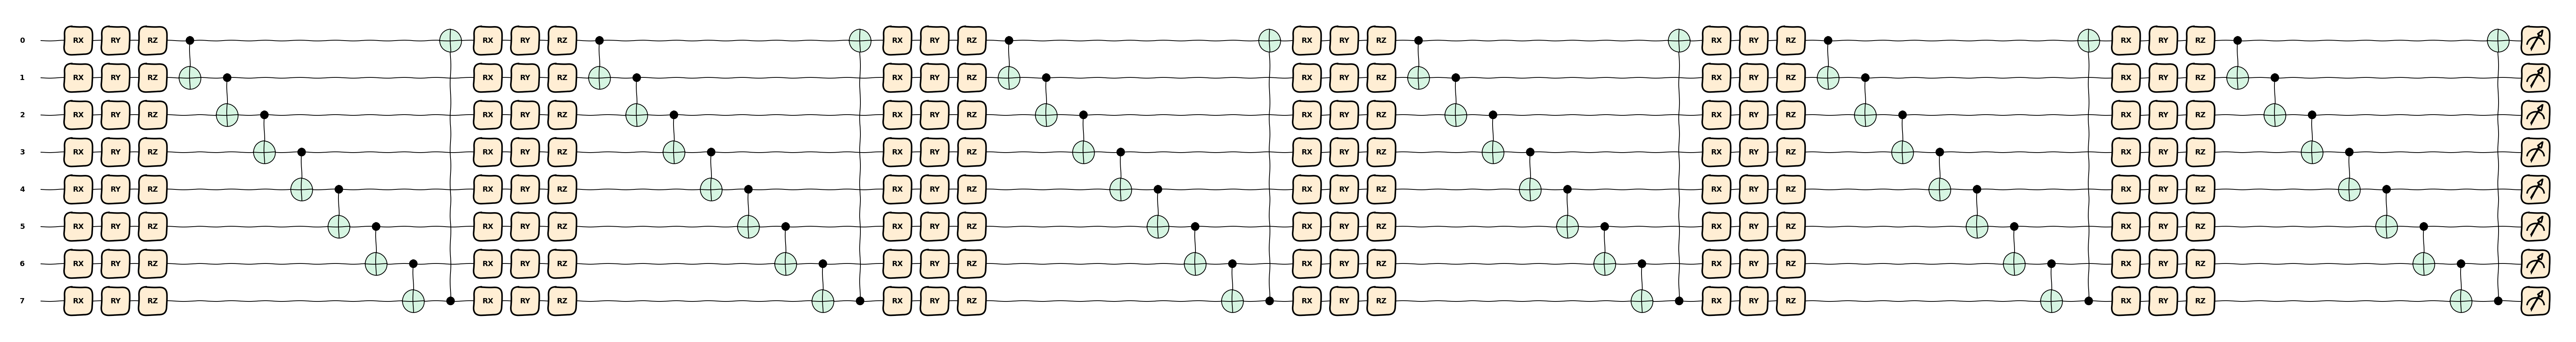

In [13]:
model.draw(style = 'sketch')

# Dataset preparation

In [18]:
labels = [0,1,2]

In [19]:
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))

In [20]:
train_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.8,batch_size=64)

# Model training

In [21]:
model.fit(dataloader=train_dataloader, learning_rate=0.01, epochs=10, show_plot=True)

Epoch 1/10:  80%|███████▉  | 185/232 [00:13<00:03, 13.97it/s, accuracy=0.844, loss=0.963]


KeyboardInterrupt: 

In [42]:
target.shape

torch.Size([32])

In [46]:
loss_function = torch.nn.NLLLoss()
log_probs = torch.log(output + 1e-9)
loss_function(log_probs, target.type(torch.int64))

tensor(1.3636, grad_fn=<NllLossBackward0>)

True

In [13]:
model.freeze_layers(list(range(model.num_layers)))
model.eval()

accuracy = []
for data, targets in test_dataloader:
    data = data / torch.linalg.norm(data, dim=1).view(-1, 1)
    output = model(data)
    accuracy.append(torch.sum((output > 0.5) == targets).item() / test_dataloader.batch_size)
    
accuracy = sum(accuracy)/len(accuracy)
print(accuracy)

0.9909018987341772
